# Vanilla Policy Gradient

## Environment

In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Select Lunar Lander v3 as environment
env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [ 0.00222149  1.4170508   0.22499315  0.27247924 -0.00256733 -0.05096437
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


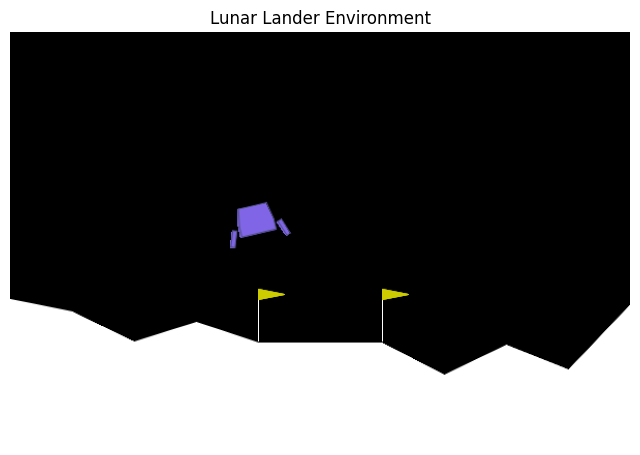

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(40):
    env.step(action=[0, 0])
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

In [4]:
from typing import List, Type

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
from torchsummary import summary

In [5]:
from models.models import ValueNetwork
from models.VPG import ContinuousPolicyNetwork, DiscretePolicyNetwork

## Plotting Help

In [6]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_metrics(episode_durations, rewards, policy_losses, value_losses, show_result=False, save_path=None):
    # Create a figure with a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0, 0].set_title("Episode Durations")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Duration")
    axes[0, 0].plot(durations_t.numpy(), label="Duration")

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0, 0].plot(means.numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[0, 1].set_title("Rewards")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Reward")
    axes[0, 1].plot(rewards_t.numpy(), label="Reward")

    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[0, 1].plot(reward_means.numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 1].legend()

    # Plot Policy Loss
    policy_t = torch.tensor(policy_losses, dtype=torch.float)
    axes[1, 0].set_title("Policy Loss")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Loss")
    axes[1, 0].plot(policy_t.numpy(), label="Policy Loss", color="orange")
    axes[1, 0].legend()

    # Plot Value Loss
    value_t = torch.tensor(value_losses, dtype=torch.float)
    axes[1, 1].set_title("Value Loss")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Loss")
    axes[1, 1].plot(value_t.numpy(), label="Value Loss", color="green")
    axes[1, 1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png", dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if "get_ipython" in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

In [7]:
BATCH_SIZE = 256
N_ACTIONS = 2
HIDDEN_DIM = 256

## 1. Value Network

We’ll create a simple feedforward neural network for the state-value function. This acts as our baseline for reducing variance in the policy gradient updates.

In [8]:
value_network = ValueNetwork(n_observations, 256)

# Generate a summary of the model
summary(value_network, input_size=(BATCH_SIZE, n_observations))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 256, 256]           2,304
            Linear-2             [-1, 256, 256]          65,792
            Linear-3               [-1, 256, 1]             257
Total params: 68,353
Trainable params: 68,353
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.00
Params size (MB): 0.26
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


/home/edreate/Desktop/Reinforcement_Learning_Course/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## 2. Discrete Policy Network

For discrete action spaces, the policy outputs a probability distribution over the discrete actions (e.g., using a Softmax). We’ll return a Categorical distribution from which we can sample actions.

For continuous action spaces, the policy outputs the mean and log_std of a Gaussian distribution. We can then sample from this Gaussian distribution to get actions.

In [9]:
policy_network = ContinuousPolicyNetwork(n_observations, N_ACTIONS, hidden_dim=HIDDEN_DIM)

summary(value_network, input_size=(BATCH_SIZE, n_observations))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 256, 256]           2,304
            Linear-2             [-1, 256, 256]          65,792
            Linear-3               [-1, 256, 1]             257
Total params: 68,353
Trainable params: 68,353
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.00
Params size (MB): 0.26
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


## 3. Collect Trajectory

We will write a helper function to collect trajectories. This function will:

- Reset the environment.
- Step through the environment using the current policy.
- Store (state, action, reward, log_prob, done) until the episode ends.
- Return lists of states, actions, log_probs, rewards, etc.

In [10]:
def collect_trajectory(env: gym.Env, policy_net: Type[nn.Module], value_net: Type[nn.Module], max_steps: int = 1000):
    """
    Collects one trajectory (episode) given a policy.
    Returns lists of states, actions, log_probs, rewards, done_flags, and values.
    """
    global steps_taken
    states = []
    actions = []
    log_probs = []
    rewards = []
    dones = []
    values = []

    state = env.reset()
    for _ in range(max_steps):
        # Get action and log_prob from policy
        action, log_prob = policy_net.get_action(state)

        # Value of the current state
        state_t = torch.FloatTensor(state).unsqueeze(0)
        value = value_net(state_t).item()

        # Step the environment
        next_state, reward, terminated, truncated, _ = env.step(action)

        steps_taken += 1

        done = terminated or truncated

        # Record
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        dones.append(done)
        values.append(value)

        state = next_state
        if done:
            break

    return states, actions, log_probs, rewards, dones, values

## 4. Advantage Calculation

We’ll compute the return (cumulative discounted reward) from each timestep, then compute the advantages by subtracting the value function (baseline).

In [11]:
def compute_advantages(rewards: List[float], values: List[float], dones: List[bool], gamma: float = 0.99):
    """
    Compute advantage using: Gt - V(st),
    where Gt is the discounted return from time t.
    """
    # Convert to numpy arrays for convenience
    rewards = np.array(rewards, dtype=np.float32)
    values = np.array(values, dtype=np.float32)
    dones = np.array(dones, dtype=np.bool)

    # Bootstrapped final value is zero for an episode
    # (or you could do a value_net(next_state) if continuing)
    returns = []
    G = 0
    for r, done in zip(rewards[::-1], dones[::-1]):
        if done:
            G = 0
        G = r + gamma * G
        returns.append(G)
    returns.reverse()
    returns = np.array(returns, dtype=np.float32)

    advantages = returns - values
    return returns, advantages

## Training

In [12]:
def train_vpg_continuous(
    env: gym.Env, state_dim, action_dim, hidden_dim=256, lr_policy=1e-3, lr_value=1e-3, gamma=0.99, max_episodes=1000
):
    global episode_durations, episode_rewards, policy_losses, value_losses

    # Initialize networks
    policy_net = ContinuousPolicyNetwork(state_dim, action_dim, hidden_dim)
    value_net = ValueNetwork(state_dim, hidden_dim)

    # Optimizers
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr_policy)
    value_optimizer = optim.Adam(value_net.parameters(), lr=lr_value)

    for episode in range(max_episodes):
        # Collect one trajectory
        (states, actions, log_probs, rewards, dones, values) = collect_trajectory(env, policy_net, value_net)

        # Compute returns and advantages
        returns, advantages = compute_advantages(rewards, values, dones, gamma)

        # Convert everything to torch tensors
        log_probs_tensor = torch.stack(log_probs)
        advantages_tensor = torch.FloatTensor(advantages)
        returns_tensor = torch.FloatTensor(returns)

        # 1. Update Policy (maximize log_prob * advantage)
        policy_optimizer.zero_grad()
        policy_loss = -(log_probs_tensor * advantages_tensor).mean()
        policy_loss.backward()
        policy_optimizer.step()

        # 2. Update Value Function (fit to returns)
        value_optimizer.zero_grad()
        states_tensor = torch.FloatTensor(states)
        value_preds = value_net(states_tensor).squeeze()
        value_loss = nn.MSELoss()(value_preds, returns_tensor)
        value_loss.backward()
        value_optimizer.step()

        # Logging
        ep_return = np.sum(rewards)
        print(f"Episode {episode}, Return: {ep_return:.2f}")

        episode_durations.append(len(dones))
        episode_rewards.append(sum(rewards))
        policy_losses.append(policy_loss.item())
        value_losses.append(value_loss.item())

        plot_metrics(episode_durations, episode_rewards, policy_losses, value_losses)

    env.close()
    return policy_net, value_net

In [13]:
episode_durations = []
episode_rewards = []
policy_losses = []
value_losses = []
steps_taken = 0
model_name = "sac_checkpoint_best"

train_vpg_continuous(env, n_observations, N_ACTIONS)

/home/edreate/Desktop/Reinforcement_Learning_Course/models/VPG.py:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.FloatTensor(state).unsqueeze(0)


ValueError: expected sequence of length 8 at dim 1 (got 0)